In [21]:
import numpy as np
import stan_jupyter as stan
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from gproc.generative import sample_at_x
from gproc.plotting import contour_2d

## Bayesian Logistic Regression

In [22]:
N = 1500 # Data size
D = 2 # Data dimension

x = np.random.uniform(-1, 1, N * D).reshape(-1, D) # Reshape to N x 2 matrix
y, prob_y, f = sample_at_x(x, kernel_params = {'variance': 3.})

# Let's do a test train split, leaving 200 points for testing
x, x_test, y, y_test = train_test_split(x, y, test_size = 0.2)

In [23]:
# Write a function to organise the data into stan friendly format

def stanvert(x, y):
    """
    Converts data to pystan friendly format

    :params X, N x d matrix, matrix of features
    :params Y, N vector, vector of responses
    
    :stan_data, dict, stan data dictionary
    """
    
    stany = np.zeros(y.shape[0])
    stany[:] = y
    
    # Set the -1's to 0's for stan
    stany[stany == -1] = 0

    # Prepare the data for stan; x = covariates, y = response, d = dimensions, n = sample size
    stan_data = {'x': x, 'y': stany.astype(int), 'd': x.shape[1], 'n': x.shape[0]}
    
    return stan_data

stan_data = stanvert(x, y)
stanvert(x, y)

{'x': array([[-0.82120662, -0.18301401],
        [-0.12731218, -0.50907695],
        [-0.07003859, -0.90359068],
        ...,
        [ 0.32449443, -0.39015899],
        [ 0.32808637, -0.50732812],
        [ 0.07299747,  0.20557447]]),
 'y': array([1, 1, 1, ..., 1, 1, 0]),
 'd': 2,
 'n': 1200}

In [24]:
# Let's define the Bayesian Logistic Regression model in stan using a N(0, I) prior on all the parameters

blr_model = """
data {
  int<lower=0> n; // number of observations
  int<lower=0> d; // number of predictors
  array[n] int<lower=0,upper=1> y; // outputs
  matrix[n,d] x; // inputs
}
parameters {
  vector[d] theta; // auxiliary parameter
}
model {
  theta ~ normal(0, 1);
  vector[n] p = x * theta;
  y ~ bernoulli_logit(p);
}
"""

In [25]:
def posterior_sampler(stan_model, stan_data, num_chains, num_samples, num_warmup):
    """
    Uses pystan to sample from a posterior distribution 
    
    :param stan_model, string, stan model code
    :param stan_data, dict, stan data dictionary
    :param num_chains, int, number of chains to sample
    :param num_samples, int, number of samples per chain
    :param num_warmup, int, number of warmup samples per chain
    
    :returns fit, stan.fit.Fit, fitted stan model containing posterior samples
    """
    posterior = stan.build(stan_model, data = stan_data)
    fit = posterior.sample(num_chains = num_chains, num_samples = num_samples, num_warmup = num_warmup)
    return fit

fit = posterior_sampler(blr_model, stan_data, 1, 2500, 500)

Building: found in cache, done.
Sampling:   0%
Sampling:   3% (100/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 7.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
  Adjust your expectations accordingly!


In [26]:
samples = fit['theta']

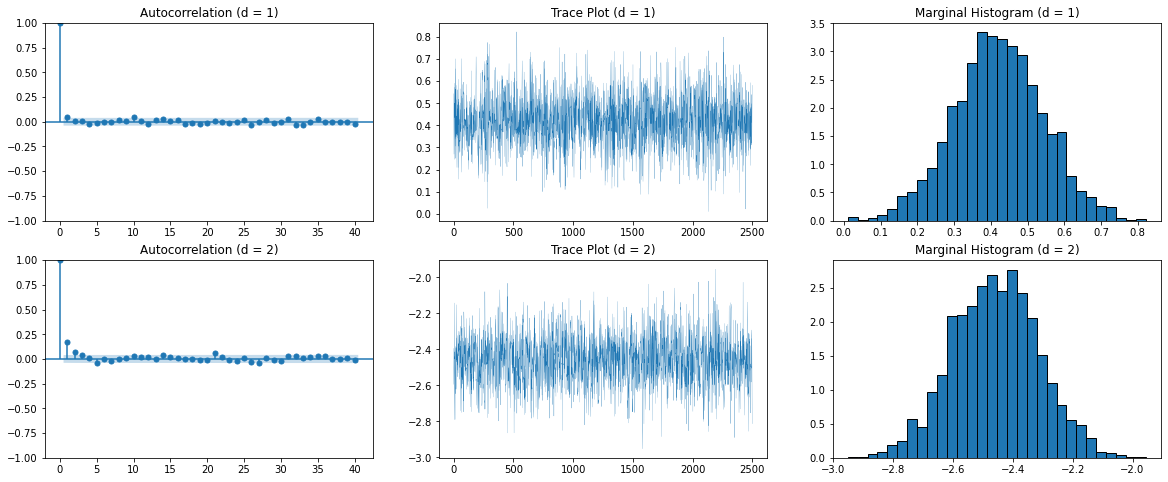

In [27]:
def inspect_samples(samples):
    """ 
    Plot the ACF, trace plots and marginal histograms of the posterior samples for each dimension
    
    :param samples, sample_size x d matrix, matrix of posterior samples  
    """
    d = samples.shape[1]
    fig, ax = plt.subplots(d, 3, figsize = (20, d*4))
    
    index = -1
    for i in range(d): 
        index += 1

        plot_acf(samples[:, i], lags = 40, ax = ax[index, 0])
        ax[index, 0].set_title(f'Autocorrelation (d = {i + 1})')
        ax[index, 1].plot(samples[:, i], linewidth = 0.2)
        ax[index, 1].set_title(f'Trace Plot (d = {i + 1})')
        ax[index, 2].hist(samples[:, i], density = True, bins = 30, ec = 'black')
        ax[index, 2].set_title(f'Marginal Histogram (d = {i + 1})')

    plt.show()

inspect_samples(samples.T)

In [37]:
x_test.shape

(300, 2)

array([[-1.46815215, -1.49202079, -1.28870778, ..., -1.30146519,
        -1.45149959, -1.67720947],
       [ 0.24196845,  0.22334779,  0.15561588, ...,  0.17867594,
         0.21619345,  0.26562973],
       [-1.11467524, -1.18112235, -1.10008692, ..., -1.06486937,
        -1.151377  , -1.29652599],
       ...,
       [-1.43702045, -1.6756324 , -1.8032443 , ..., -1.61572273,
        -1.64051297, -1.74465558],
       [-0.16693773, -0.19299859, -0.20530658, ..., -0.18506342,
        -0.18888379, -0.20188179],
       [ 0.76029218,  0.81190964,  0.76619008, ...,  0.73631929,
         0.79175393,  0.88734086]])

In [64]:
# Lets do some prediction using the posterior predictive distribution

# Sample from the predictive distribution
def blr_predictive(x_test, samples):
    """
    Sample from the Bayesian logisitic regression predictive distribution
    
    :param x_test, N x d matrix, matrix of test inputs
    :param samples, sample_size x d matrix, matrix of posterior samples
    
    :returns probs, N x sample_size matrix, matrix of predictive probabilities
    :returns y_preds, N x sample_size matrix, matrix of predictive samples
    :returns prob_ests, N vector, vector of predictive probability point estimates
    :returns y_ests, N vector, vector of prediction point estimates  
    """
    # Initialise arrays to hold predictive probabilities and predictive samples
    # for each test point and posterior sample
    probs = np.zeros((x_test.shape[0], samples.shape[0]))
    y_preds = np.zeros((x_test.shape[0], samples.shape[1]))
    
    # For each test point, and posterior sample, compute the probability of label 1
    probs = 1/(1 + np.exp(-x_test.dot(samples)))
    y_preds[probs >= 0.5] = 1
    y_preds[probs < 0.5] = -1
    
    # Compute the point estimate of the probability that each test point is zero
    prob_ests = np.mean(probs, axis = 1)
    
    #Compute the point estimate of the label for each test point
    y_ests = np.mean(y_preds, axis = 1)
    y_ests[y_ests < 0] = -1
    y_ests[y_ests >= 0] = 1
    
    return probs, y_preds, prob_ests, y_ests

probs, preds, prob_ests, y_ests = blr_predictive(x_test, samples)

In [59]:
def max_threshold(prob_ests):
    """
    Computes the maximum value of the abstention threshold
    
    :param prob_ests, N vector, vector of predictive probability point estimates

    :returns max_thresh, float[0. 1], threshold value that removes all data
    """
    
    # Work out the two possiblities
    thresh1 = 0.5 - np.min(prob_ests)
    thresh2 = np.max(prob_ests) - 0.5
    
    # Find the maximum threshold value
    if thresh2 > thresh1:
        max_thresh = thresh2
    else:
        max_thresh = thresh1
        
    return max_thresh



In [60]:
def predictive_metrics(prob_ests, y_ests, y_test, rho):
    """
    Computes the capacity accuracy, capacity F score and capacity AUC scores
    
    :param prob_ests, N vector, vector of predictive probability point estimates
    :param y_ests, N vector, vector of prediction point estimates  
    :param y_tests, N vector, vector of test responses
    :param rho, float[0, 1], prediction certainity threshold value
    
    :returns abstention_degree, float[0. 1], proportion of test data retained after thresholding
    :returns cap_acc_score, float[0, 1], capacity classification accuracy
    :returns cap_F_score, float[0, 1], capacity F score
    :returns cap_AUC_score, float[0, 1], capacity AUC score
    """
    # Number of test points
    N = y_test.shape[0]
    
    # Find the indices that pass the certainty threshold
    thresh_inds = np.argwhere((prob_ests < 0.5 - rho) | (prob_ests > 0.5 + rho))
    
    # Work out degree of abstention
    abstention_degree = thresh_inds.shape[0]/N

    if abstention_degree == 0:
        raise ValueError("Threshold value too large, no data passes")
    
    # Get thresholded predicted and test responses, and probabilities
    y_test_threshed = y_test[thresh_inds]
    y_ests_threshed = y_ests[thresh_inds]
    prob_ests_thresed = prob_ests[thresh_inds]
    
    if (np.unique(y_test_threshed).shape[0] == 1) | (np.unique(y_ests_threshed).shape[0] == 1):
        raise ValueError("Threshold value too large, only one class")
        
    # Work out the capacity classifcication accuracy
    cap_acc_score = np.mean(y_test_threshed == y_ests_threshed)
    
    # Work out the capacity  F score 
    cap_F_score = f1_score(y_test_threshed, y_ests_threshed)
    
    # Work out the capacity  AUC score
    cap_AUC_score = roc_auc_score(y_test_threshed, prob_ests_thresed)
    
    return abstention_degree, cap_acc_score, cap_F_score, cap_AUC_score

In [61]:
predictive_metrics(prob_ests, y_ests, y_test, 0.1)

(0.8266666666666667, 0.842741935483871, 0.8571428571428571, 0.8686553281955885)

In [62]:
def abstention_metrics(prob_ests, y_ests, y_test, rhos):
    """
    Computes the capacity accuracy, capacity F score and capacity AUC scores
    
    :param prob_ests, N vector, vector of predictive probability point estimates
    :param y_ests, N vector, vector of prediction point estimates  
    :param y_tests, N vector, vector of test responses
    :param rhos, M vector, threshold values
    
    :returns cap_metrics, M x 4 matrix, matrix holding abstention degree, capacity classification
                                        accuracy capacity F score, capacity AUC score
    """

    cap_metrics = np.zeros((rhos.shape[0], 4))

    for i in range(rhos.shape[0]):
        try:
            cap_metrics[i, :] = predictive_metrics(prob_ests, y_ests, y_test, rhos[i])
        except ValueError:
            return cap_metrics[0:i, ]
        
    return cap_metrics

rhos = np.linspace(0, max_threshold(prob_ests), 1000)
cap_metrics = abstention_metrics(prob_ests, y_ests, y_test, rhos)

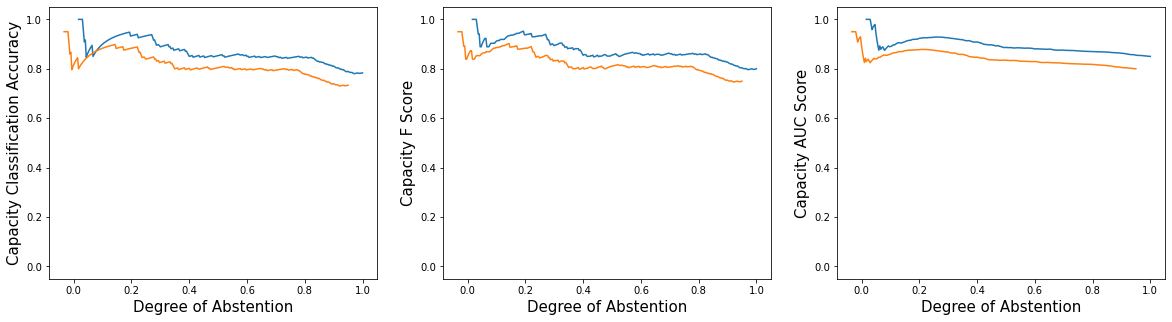

In [63]:
def inspect_metrics(accuracy_ax, f_score_ax, auc_ax, cap_metrics):
    """
    Produces plots of the capacity accuracy, capacity F score and capacity AUC scores vs
    the degree of abstention
    
    :param cap_metrics, M x 4 matrix, matrix holding abstention degree, capacity classification
                                        accuracy capacity F score, capacity AUC score
    """
    
    
    accuracy_ax.plot(cap_metrics[:, 0], cap_metrics[:, 1], label = 'Capacity Accuracy Score')
    accuracy_ax.set_xlabel('Degree of Abstention', fontsize = 15)
    accuracy_ax.set_ylabel('Capacity Classification Accuracy', fontsize = 15)
    accuracy_ax.set_ylim([-0.05, 1.05])
    
    f_score_ax.plot(cap_metrics[:, 0], cap_metrics[:, 2], label = 'Capacity F Score')
    f_score_ax.set_xlabel('Degree of Abstention', fontsize = 15)
    f_score_ax.set_ylabel('Capacity F Score', fontsize = 15)
    f_score_ax.set_ylim([-0.05, 1.05])
    
    auc_ax.plot(cap_metrics[:, 0], cap_metrics[:, 3], label = 'Capacity AUC Score')
    auc_ax.set_xlabel('Degree of Abstention', fontsize = 15)
    auc_ax.set_ylabel('Capacity AUC Score', fontsize = 15)
    auc_ax.set_ylim([-0.05, 1.05])
    
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

inspect_metrics(ax[0], ax[1], ax[2], cap_metrics)
inspect_metrics(ax[0], ax[1], ax[2], cap_metrics - 0.05)